# 模組 3.4: 案例實戰 - House Prices 資料集

## 學習目標
- 綜合運用本模組學習到的缺失值與異常值處理技術。
- 遵循系統化的流程，對一個真實的資料集進行初步的數據清理。
- 根據特徵的上下文和業務邏輯，制定合理的清理策略。
- 為後續的特徵工程和模型建立準備一個更乾淨、更可靠的資料集。

## 導論：整合與應用

理論和單一技術的學習是基礎，但真正的挑戰在於如何將它們綜合應用於一個複雜的真實資料集。House Prices 資料集充滿了各種數據品質問題，是練習本模組技能的絕佳場景。

在這個筆記本中，我們將扮演一個資料分析師的角色，接收原始的 `train.csv`，並產出一個經過初步清理的版本，為下一階段的分析做好準備。

In [16]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 設定視覺化風格和 Pandas 選項
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
print("Libraries and styles configured.")

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False


# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')




Libraries and styles configured.


## 1. 載入資料與初步檢視

我們將再次載入資料，並建立一個工作副本 `df_processed`，以保留原始資料的完整性。

In [17]:
# 載入資料
path = r'..\..\..\..\datasets\raw\house_prices\train.csv'
try:
    df = pd.read_csv(path)
    df_processed = df.copy()
    print("成功載入 House Prices 資料集!")
    print(f"資料集維度: {df_processed.shape}")
except FileNotFoundError:
    print(f"在 '{path}' 找不到 train.csv。")
    df_processed = pd.DataFrame()



成功載入 House Prices 資料集!
資料集維度: (1460, 81)


## 2. 處理異常值

根據我們在 `03_outlier_detection.py` 中的發現，`GrLivArea` (地上生活面積) 中有兩個非常明顯的異常點，它們的面積極大但房價卻極低。這種異常點會嚴重干擾模型的學習，我們決定將其移除。

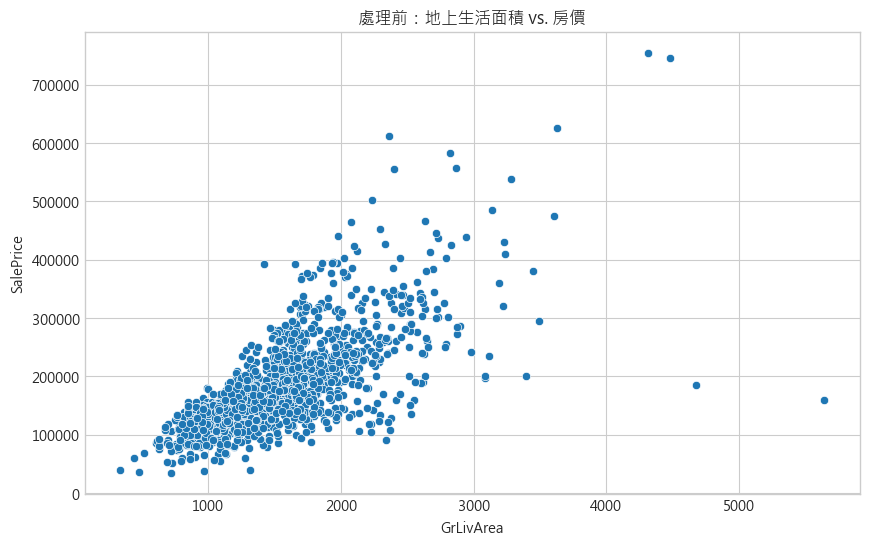

In [18]:
# 視覺化異常點
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_processed['GrLivArea'], y=df_processed['SalePrice'])
plt.title('處理前：地上生活面積 vs. 房價')
plt.show()



In [19]:
# 移除 GrLivArea > 4000 且 SalePrice < 300000 的異常點
outlier_indices = df_processed[(df_processed['GrLivArea'] > 4000) & (df_processed['SalePrice'] < 300000)].index
df_processed = df_processed.drop(outlier_indices)

print(f"已移除 {len(outlier_indices)} 個關於 GrLivArea 的異常值。")



已移除 2 個關於 GrLivArea 的異常值。


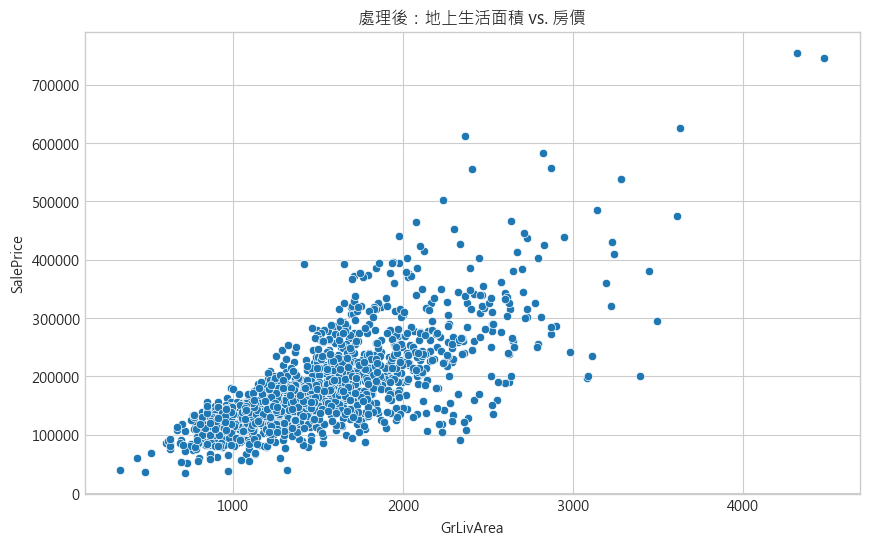

In [20]:
# 檢查移除後的效果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_processed['GrLivArea'], y=df_processed['SalePrice'])
plt.title('處理後：地上生活面積 vs. 房價')
plt.show()



## 3. 處理缺失值 (分策略進行)

現在我們來系統性地處理缺失值。我們將根據在 `01_missing_data_overview.py` 中對缺失值成因的判斷來分組處理。

### 策略一：填充為 "None" 或 0 (針對 MNAR - 非隨機缺失)

這些特徵的缺失代表「不存在」該設施。對於類別型特徵，我們用 "None" 填充；對於數值型，用 0 填充。

In [21]:
# 類別型特徵，缺失代表 "無"
cols_fill_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
]
for col in cols_fill_none:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('None')

# 數值型特徵，缺失代表 "無"
cols_fill_zero = [
    'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]
for col in cols_fill_zero:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna(0)

print("已完成第一輪 MNAR 缺失值填充。")



已完成第一輪 MNAR 缺失值填充。


### 策略二：使用眾數填充 (針對少量隨機缺失的類別特徵)

對於那些只有極少量缺失，且看起來是隨機發生的類別特徵，使用該欄位的眾數（最常見的值）來填充是一個簡單而合理的選擇。

In [22]:
# 'Electrical' 和 'MSZoning' 等都屬於這種情況
cols_fill_mode = ['MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Electrical']

for col in cols_fill_mode:
    if col in df_processed.columns and df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()[0]
        df_processed[col] = df_processed[col].fillna(mode_val)
        print(f"已使用眾數 '{mode_val}' 填充 '{col}' 的缺失值。")



已使用眾數 'SBrkr' 填充 'Electrical' 的缺失值。


### 策略三：使用中位數填充 (針對有偏態的數值特徵)

`LotFrontage` (街道連接的線性英尺) 是一個典型的例子。它的缺失可能與其他因素有關（例如地塊大小），但一個穩健的簡單策略是用中位數填充，因為它的分佈是偏態的。

In [23]:
if 'LotFrontage' in df_processed.columns and df_processed['LotFrontage'].isnull().any():
    median_val = df_processed['LotFrontage'].median()
    df_processed['LotFrontage'] = df_processed['LotFrontage'].fillna(median_val)
    print(f"已使用中位數 '{median_val}' 填充 'LotFrontage' 的缺失值。")



已使用中位數 '69.0' 填充 'LotFrontage' 的缺失值。


## 4. 最終檢查

讓我們最後一次檢查是否還有剩餘的缺失值。

In [24]:
remaining_missing = df_processed.isnull().sum().sum()
if remaining_missing == 0:
    print("恭喜！所有已知的缺失值都已處理完畢。")
else:
    print(f"警告：資料集中仍有 {remaining_missing} 個缺失值。")
    print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])



警告：資料集中仍有 872 個缺失值。
MasVnrType    872
dtype: int64


## 總結與產出

在這個案例中，我們：
1. **移除了明顯干擾分析的異常值**。
2. **根據業務邏輯對大量缺失值進行了有意義的填充**，將「不存在」這種資訊保留了下來。
3. **對少量隨機缺失的值採用了穩健的統計量進行填充**。

現在，`df_processed` 這個 DataFrame 已經比原始資料乾淨得多，為後續的特徵工程和模型建立打下了堅實的基礎。在真實的專案中，我們可能會將這個清理後的 DataFrame 儲存到一個新的 CSV 檔案中。

In [25]:
# 例如，可以將其儲存到 processed 資料夾
# output_path = 'data_mining_course/datasets/processed/house_prices/train_cleaned.csv'
# df_processed.to_csv(output_path, index=False)
# print(f"清理後的資料已儲存至: {output_path}") 